In [2]:

# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [41]:
df = pd.read_csv('data/swerve_test_00.csv')

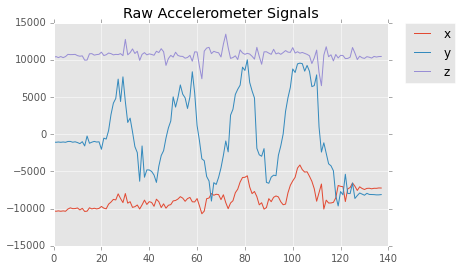

In [42]:
plt.plot(df['ax'], label='x')
plt.plot(df['ay'], label='y')
plt.plot(df['az'], label='z')
plt.title('Raw Accelerometer Signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

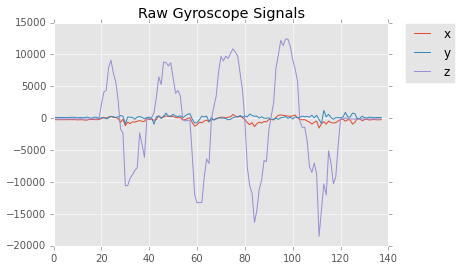

In [43]:
plt.plot(df['gx'], label='x')
plt.plot(df['gy'], label='y')
plt.plot(df['gz'], label='z')
plt.title('Raw Gyroscope Signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)